In [3]:
from __future__ import (unicode_literals, print_function, absolute_import,
                        division)

from ema_workbench import (Model, MultiprocessingEvaluator, Policy,
                           Scenario)

from ema_workbench.em_framework.evaluators import perform_experiments, SOBOL, LHS
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.util import ema_logging
import time
from problem_formulation import get_model_for_problem_formulation

if __name__ == '__main__':
    ema_logging.log_to_stderr(ema_logging.INFO)
 
    model, planning_steps = get_model_for_problem_formulation(3)

    # Build a user-defined scenario and policy:
    reference_values = {'Bmax': 175, 'Brate': 1.5, 'pfail': 0.5,
                        'ID flood wave shape': 4, 'planning steps': 2}
    reference_values.update({'discount rate {}'.format(n): 3.5 for n in planning_steps})
    scen1 = {}

    for key in model.uncertainties:
        name_split = key.name.split('_')

        if len(name_split) == 1:
            scen1.update({key.name: reference_values[key.name]})

        else:
            scen1.update({key.name: reference_values[name_split[1]]})

    ref_scenario = Scenario('reference', **scen1)

    # no dike increase, no warning, none of the rfr
    zero_policy = {'DaysToThreat': 0}
    zero_policy.update({'DikeIncrease {}'.format(n): 0 for n in planning_steps})
    zero_policy.update({'RfR {}'.format(n): 0 for n in planning_steps})
    pol0 = {}

    for key in model.levers:
        s1, s2 = key.name.split('_')
        pol0.update({key.name: zero_policy[s2]})

    policy0 = Policy('Policy 0', **pol0)

In [2]:
with MultiprocessingEvaluator(model) as evaluator:
    experiments_pol0, outcomes_pol0 = evaluator.perform_experiments(scenarios=10000, policies=policy0,
                                                                    uncertainty_sampling=LHS)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 10000 scenarios * 1 policies * 1 model(s) = 10000 experiments
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] 7000 cases completed
[MainProcess/INFO] 8000 cases completed
[MainProcess/INFO] 9000 cases completed
[MainProcess/INFO] 10000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [3]:
from ema_workbench import save_results, load_results

save_results((experiments_pol0, outcomes_pol0), './results_pol0.tar.gz')

NameError: name 'experiments_pol0' is not defined

In [1]:
from ema_workbench import load_results
experiments_pol0, outcomes_pol0 = load_results('results_pol0.tar.gz')

In [2]:
import pandas as pd
pd.set_option('display.max_columns', None)
dropset = ['model', 'EWS_DaysToThreat', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1', 'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1', 'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1', 'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1', 'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1', 'A.5_DikeIncrease 2', '0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0', '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0', '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2']
experiments_cleaned = experiments_pol0.drop(dropset, axis=1)

In [3]:
data = outcomes_pol0['Expected Number of Deaths']
data

array([0.97267961, 0.47995929, 0.41024744, ..., 3.21985316, 2.17990289,
       0.40912404])

In [4]:
import numpy as np
from ema_workbench.analysis import prim

y = data < np.percentile(data, 20)

prim_alg = prim.Prim(experiments_cleaned, y, threshold=1, peel_alpha=0.1)
box1 = prim_alg.find_box()

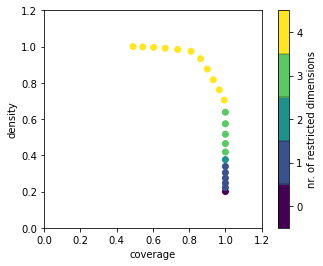

In [5]:
import matplotlib.pyplot as plt
box1.show_tradeoff()
plt.show()

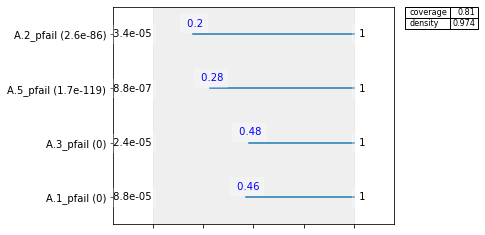

In [6]:
box1.inspect(17,style='graph')
plt.show()

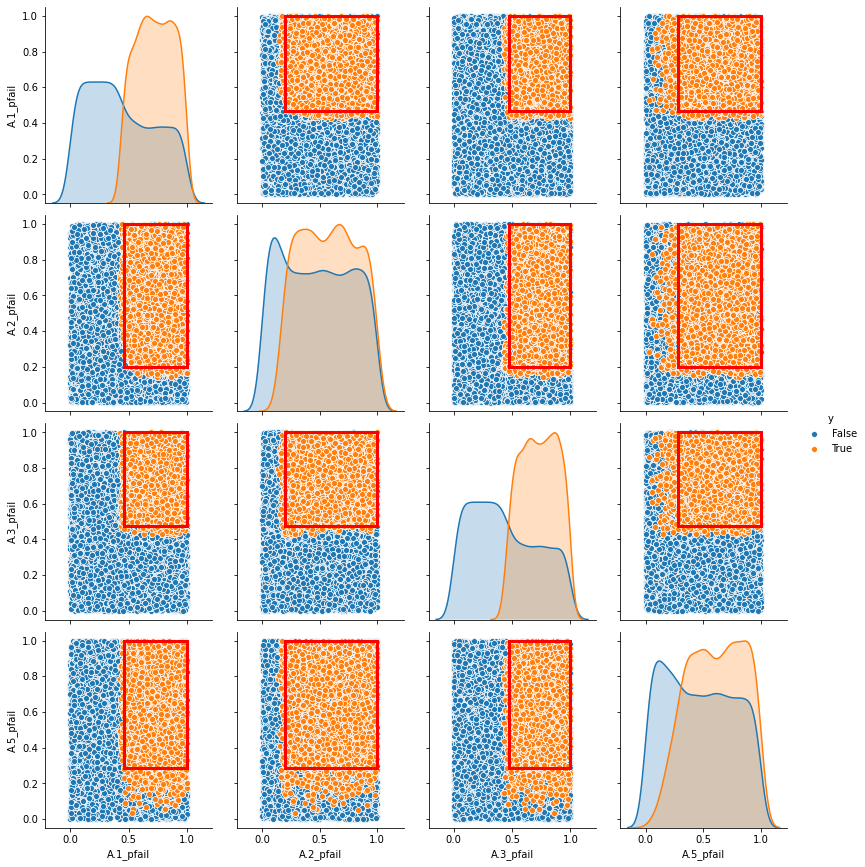

In [7]:
box1.select(17)
box1.show_pairs_scatter()
fig = plt.gcf()
fig.set_size_inches(12,12)
plt.show()

In [8]:
from ema_workbench.analysis import dimensional_stacking

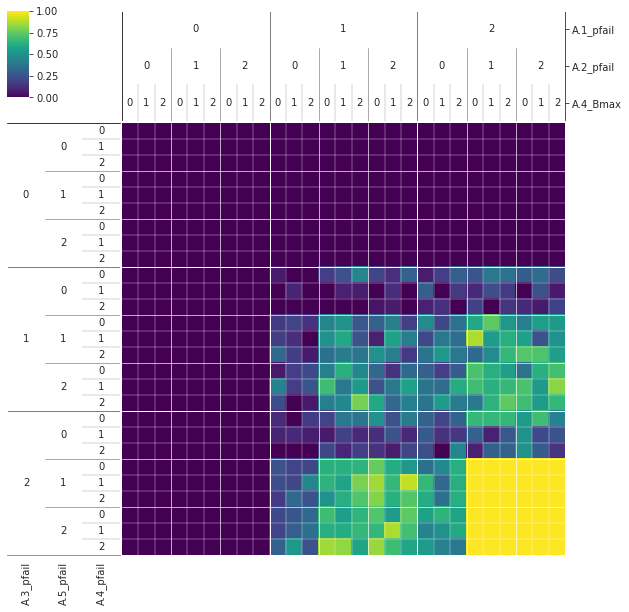

In [9]:
experiments_stack = experiments_cleaned.drop(['discount rate 0', 'discount rate 1', 'discount rate 2'], axis=1)
dimensional_stacking.create_pivot_plot(experiments_stack, y)
plt.show()

<Figure size 576x576 with 0 Axes>

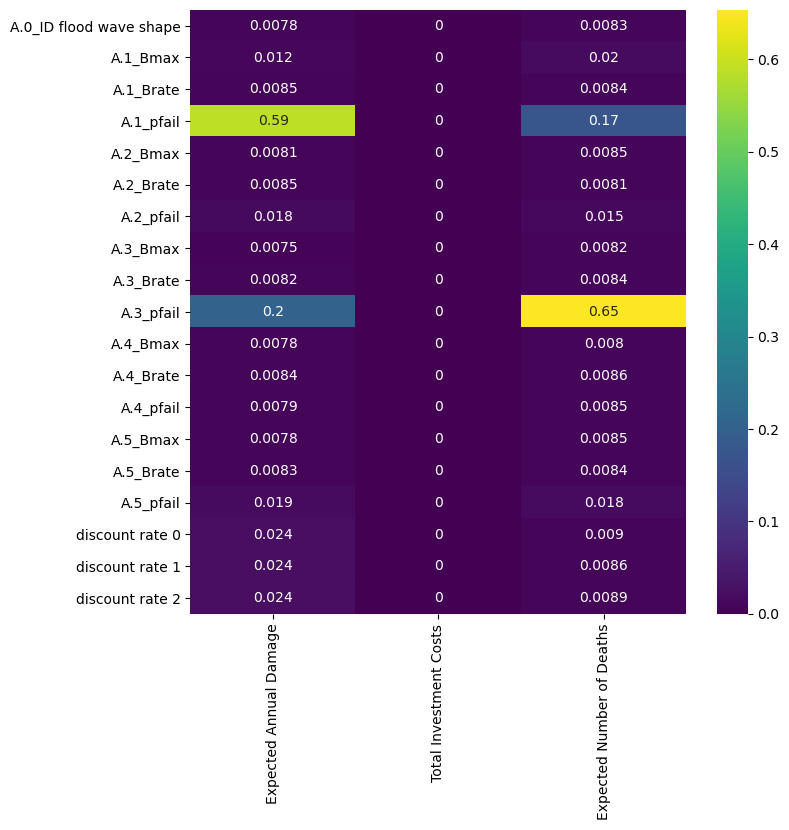

In [10]:
from ema_workbench.analysis import feature_scoring
import seaborn as sns

fig = plt.figure(figsize=(8, 8))

for policy in experiments_cleaned.policy.unique():
    plt.figure(figsize=(8, 8), dpi=100)
    logical = experiments_cleaned.policy == policy
    subset_results = {k:v[logical] for k,v in outcomes_pol0.items()}
    scores = feature_scoring.get_feature_scores_all(experiments_cleaned[logical],
                                                   subset_results)
    sns.heatmap(scores, annot=True, cmap='viridis')
    plt.savefig('NoPolicy_heatmap.png', bbox_inches='tight')
    plt.show()

C:\Users\engbn\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


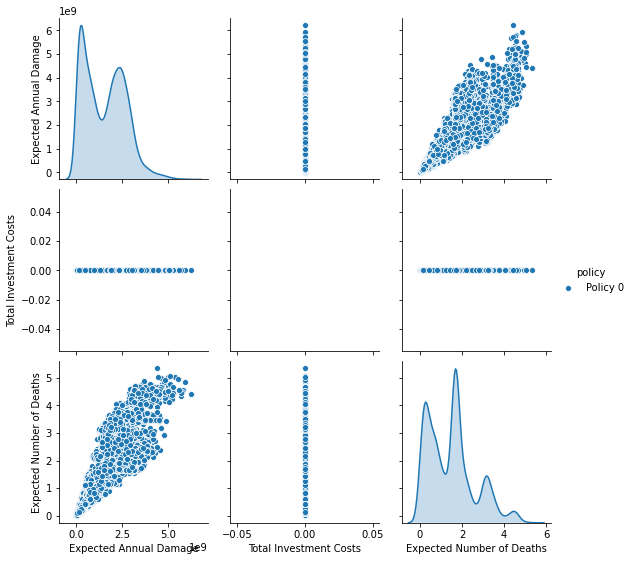

In [11]:
policies = experiments_pol0['policy']

data = pd.DataFrame.from_dict(outcomes_pol0)
data['policy'] = policies

sns.pairplot(data, hue='policy',  vars=outcomes_pol0.keys(), )
plt.show()